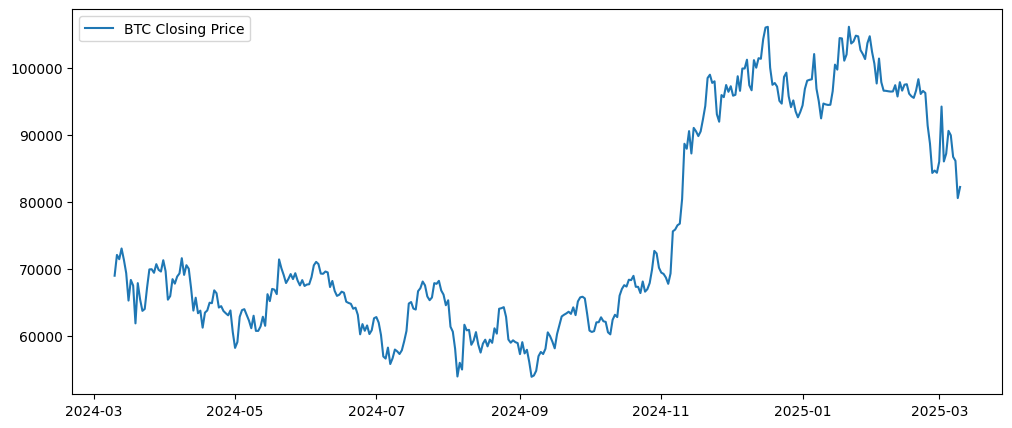

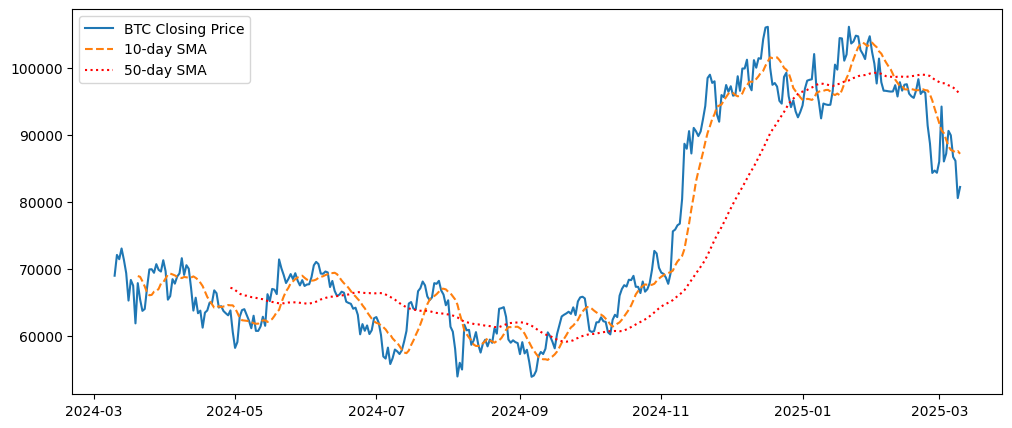

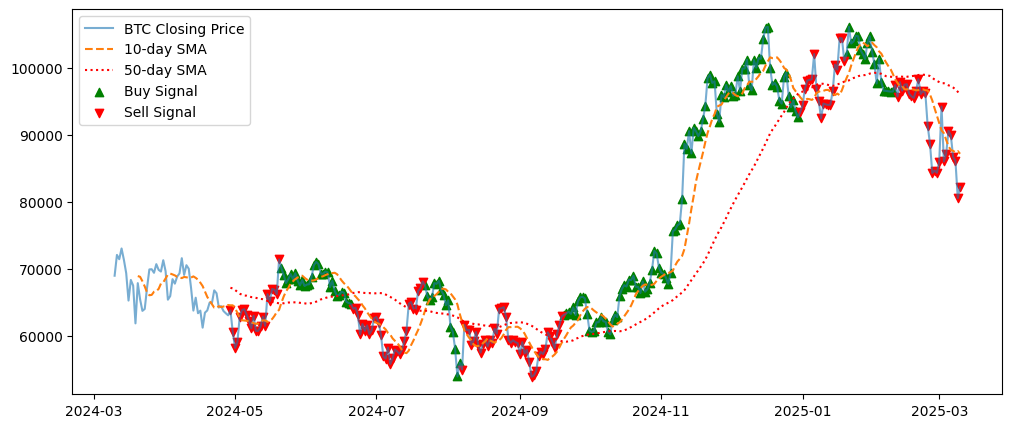

Baseline Accuracy (always hold): 0.00
Model Accuracy: 0.97


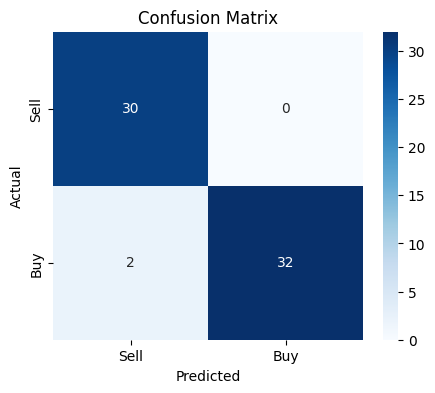

              precision    recall  f1-score   support

          -1       0.94      1.00      0.97        30
           1       1.00      0.94      0.97        34

    accuracy                           0.97        64
   macro avg       0.97      0.97      0.97        64
weighted avg       0.97      0.97      0.97        64

Model Accuracy: 0.97
              precision    recall  f1-score   support

          -1       0.94      1.00      0.97        30
           1       1.00      0.94      0.97        34

    accuracy                           0.97        64
   macro avg       0.97      0.97      0.97        64
weighted avg       0.97      0.97      0.97        64

Signal
 1    170
-1    146
Name: count, dtype: int64


In [ ]:
# *** Fetch Stock/Crypto Data using yfinance ***

import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression


# Fetch Bitcoin data
btc = yf.Ticker("BTC-USD")
btc_data = btc.history(period="1y")

# Plot Closing Prices
plt.figure(figsize=(12,5))
plt.plot(btc_data.index, btc_data["Close"], label="BTC Closing Price")
plt.legend()
plt.show()

# Display Data
btc_data.head()

# Basic Moving Average Model
# 10-day SMA
btc_data["SMA_10"] = btc_data["Close"].rolling(window=10).mean().shift(1)  # 10-day SMA

# 50-day SMA
btc_data["SMA_50"] = btc_data["Close"].rolling(window=50).mean().shift(1)  # 50-day SMA

# Plot prices and SMAs
plt.figure(figsize=(12,5))
plt.plot(btc_data.index, btc_data["Close"], label="BTC Closing Price")
plt.plot(btc_data.index, btc_data["SMA_10"], label="10-day SMA", linestyle="dashed")
plt.plot(btc_data.index, btc_data["SMA_50"], label="50-day SMA", linestyle="dotted", color="red")
plt.legend()
plt.show()

# Trading Singals
btc_data["Signal"] = 0 # Default: No action
btc_data.loc[btc_data["SMA_10"] > btc_data["SMA_50"], "Signal"] = 1 # Buy Signal
btc_data.loc[btc_data["SMA_10"] < btc_data["SMA_50"], "Signal"] = -1 # Sell Signal

# Plot Buy (Greeb) and Sell (Red) Points
plt.figure(figsize=(12,5))
plt.plot(btc_data.index, btc_data["Close"], label="BTC Closing Price", alpha=0.6)
plt.plot(btc_data.index, btc_data["SMA_10"], label="10-day SMA", linestyle="dashed")
plt.plot(btc_data.index, btc_data["SMA_50"], label="50-day SMA", linestyle="dotted", color="red")

# Mark Buy and Sell Signals
plt.scatter(btc_data.index[btc_data["Signal"] == 1], btc_data["Close"][btc_data["Signal"] == 1], label="Buy Signal", marker="^", color="g", alpha=1)
plt.scatter(btc_data.index[btc_data["Signal"] == -1], btc_data["Close"][btc_data["Signal"] == -1], label="Sell Signal", marker="v", color="r", alpha=1)

plt.legend()
plt.show()

# Prepare Data for ML
btc_data["Price Change"] = btc_data["Close"].pct_change()  # Daily Price Change
btc_data["Volatility"] = btc_data["Close"].rolling(window=10).std().shift(1)   # 10-day Volatility
btc_data.dropna(inplace=True)  # Drop NaN values

# Select features for ML
features = ["SMA_10", "SMA_50", "Price Change", "Volatility"]
x = btc_data[features]
# Target variable
y = btc_data["Signal"] 

btc_data.head()

# Split Data
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

# TESTING
# Dummy Baseline
y_dummy = [0] * len(y_test)
baseline_accuracy = accuracy_score(y_test, y_dummy)
print(f"Baseline Accuracy (always hold): {baseline_accuracy:.2f}")


# Scale Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Logistic Regression Model
model = LogisticRegression(class_weight="balanced")
model.fit(X_train_scaled, y_train)

# Model Evaluation
y_pred = model.predict(X_test_scaled) # Make Predictions
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Sell", "Buy"], yticklabels=["Sell", "Buy"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print(classification_report(y_test, y_pred))

btc_data.head()

# Evaluate Model
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")

# Detailed Classification Report
print(classification_report(y_test, y_pred))

print(y.value_counts())


